<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, Input
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model

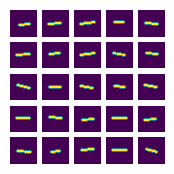

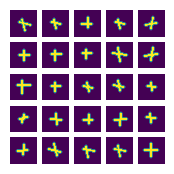

In [8]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [9]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #7623

X_text: "38-11" = y_text: "27 "


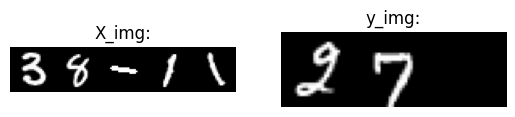

Query #7941

X_text: "39-70" = y_text: "-31"


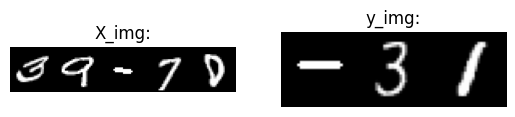

Query #6255

X_text: "31-27" = y_text: "4  "


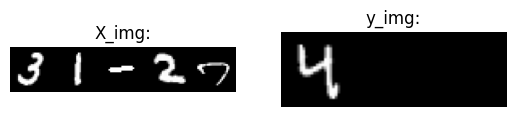

Query #3847

X_text: "19-23" = y_text: "-4 "


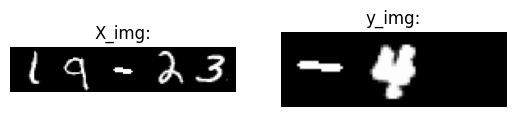

Query #2047

X_text: "10-23" = y_text: "-13"


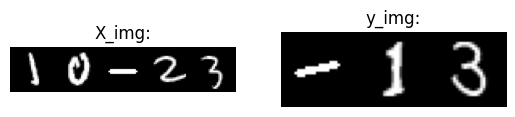

Query #6692

X_text: "33+46" = y_text: "79 "


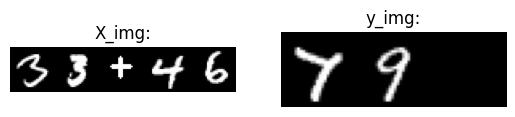

Query #6929

X_text: "34-64" = y_text: "-30"


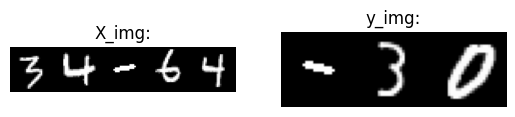

Query #7327

X_text: "36-63" = y_text: "-27"


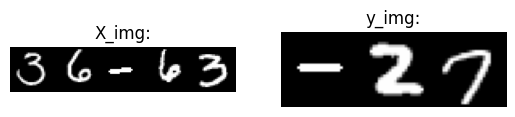

Query #1373

X_text: "6-86 " = y_text: "-80"


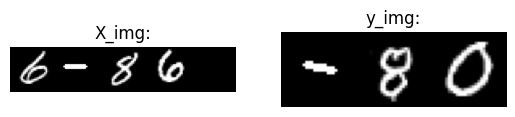

Query #7429

X_text: "37-14" = y_text: "23 "


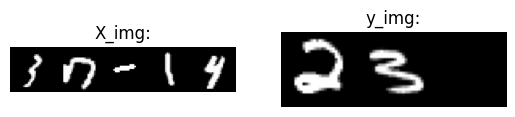

In [10]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [11]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):

def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

from collections import Counter

# Modified function to collect all misclassification errors
def collect_misclassification_errors(predictions, y_test):
    errors = []
    for idx in range(len(predictions)):
        predicted_label = decode_labels(predictions[idx])
        true_label = decode_labels(y_test[idx])
        if predicted_label != true_label:
            errors.append((idx, true_label, predicted_label))
    return errors

def display_top_misclassification_mistakes(errors, X_test_encoded):
    print("Top 10 Misclassification Mistakes:")
    error_counter = Counter((true_label, predicted_label) for _, true_label, predicted_label in errors)

    for mistake, count in error_counter.most_common(10):
        true_label, predicted_label = mistake
        indices = [idx for idx, true, pred in errors if true == true_label and pred == predicted_label][:10]

        print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Count: {count}")
        for idx in indices:
            query = decode_one_hot(X_test_encoded[idx])
            print(f"  Query '{query}' at Index {idx}")

# Splits for training and testing
splits = [(0.8, 0.2), (0.5, 0.5), (0.25, 0.75), (0.1, 0.9)]

# Collecting errors for each split
split_errors = {}

# Initializing dictionaries to store accuracy data
train_accuracies = {}
val_accuracies = {}

for train_size, test_size in splits:
    print(f"Training with split {train_size}-{test_size}")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=train_size, test_size=test_size, random_state=42)

    # Build and train the model
    model = build_text2text_model()
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

    # Storing accuracies for plotting
    train_accuracies[f"{train_size}"] = history.history['accuracy']
    val_accuracies[f"{train_size}"] = history.history['val_accuracy']

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy}")

    # Collect misclassification errors
    predictions = model.predict(X_test)
    split_errors[f"{train_size}"] = collect_misclassification_errors(predictions, y_test)

Training with split 0.8-0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 3, 13)             3341      
 ributed)                                                        
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________

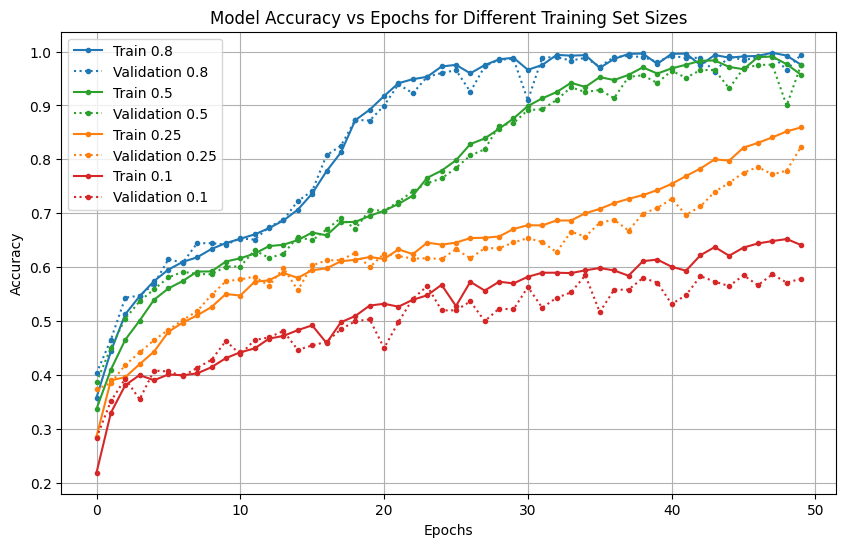

In [ ]:
# Define a list of colors for the plots
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

# Plotting
plt.figure(figsize=(10, 6))
for i, train_size in enumerate(splits):
    split = train_size[0]
    color = colors[i]
    plt.plot(train_accuracies[f"{split}"], label=f"Train {split}", color=color, marker='.')
    plt.plot(val_accuracies[f"{split}"], linestyle='dotted', label=f"Validation {split}", color=color, marker='.')

plt.title("Model Accuracy vs Epochs for Different Training Set Sizes")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

For the 80/20 test split, we observe an accuracy of 99.3%. Also, the lower train splits (0.25 and 0.1) start overfitting after 30 epochs.

In [ ]:
# Display top misclassification mistakes for each split
for train_size, errors in split_errors.items():
    print(f"\nFor Training Split {train_size}")
    display_top_misclassification_mistakes(errors, X_test)


For Training Split 0.8
Top 10 Misclassification Mistakes:
True Label: 40 , Predicted Label: 30 , Count: 7
  Query '15+25' at Index 754
  Query '56-16' at Index 1039
  Query '16+24' at Index 1614
  Query '9+31 ' at Index 1674
  Query '1+39 ' at Index 1756
  Query '93-53' at Index 3548
  Query '54-14' at Index 3876
True Label: 4  , Predicted Label: 5  , Count: 7
  Query '43-39' at Index 1573
  Query '88-84' at Index 1708
  Query '33-29' at Index 1950
  Query '42-38' at Index 2156
  Query '89-85' at Index 2565
  Query '73-69' at Index 3263
  Query '78-74' at Index 3770
True Label: 2  , Predicted Label: 3  , Count: 6
  Query '20-18' at Index 404
  Query '31-29' at Index 889
  Query '18-16' at Index 2472
  Query '41-39' at Index 2516
  Query '28-26' at Index 2888
  Query '48-46' at Index 3475
True Label: 20 , Predicted Label: 10 , Count: 4
  Query '14+6 ' at Index 1125
  Query '16+4 ' at Index 2414
  Query '13+7 ' at Index 3400
  Query '93-73' at Index 3787
True Label: -80, Predicted Label

For the mistakes, we observe that the lower splits make more simple mistakes (having a single digit wrong when the answer is also a single digit), while the higher train splits have more advanced mistakes (a single mistake in a double digit answer). Also higher train splits have less mistakes than lower train splits in general. This shows that the higher train splits get past the "easy" predictions and only start failing occasionally at more difficult predictions.


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 28, 28, 1)]    0         
                                                                 
 time_distributed_13 (TimeD  (None, 5, 26, 26, 32)     320       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 5, 13, 13, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 5, 5408)           0         
 istributed)                                                     
                                                                 
 lstm_18 (LSTM)              (None, 128)               2834944   
                                                           

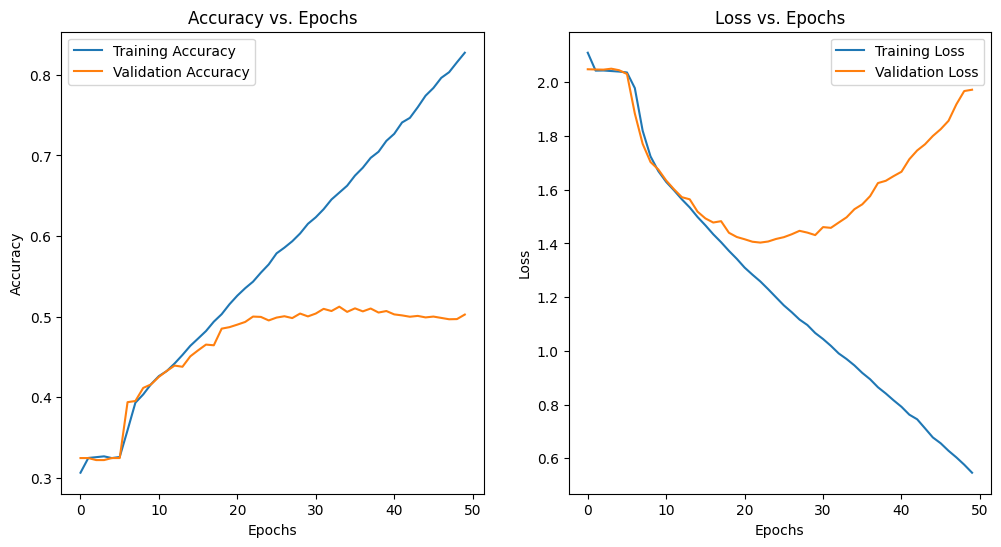

In [ ]:
### 1.3 Image-to-text model

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

def build_image_to_text_model():
    input_shape = (5, 28, 28, 1)  # 5 images, each 28x28 pixels, 1 channel (grayscale)

    # Input layer for image sequences
    input_layer = Input(shape=input_shape)

    # CNN for feature extraction from each image, wrapped in TimeDistributed
    cnn = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'))(input_layer)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
    cnn = TimeDistributed(Flatten())(cnn)

    # RNN (LSTM) for understanding the sequence
    lstm = LSTM(128)(cnn)

    # RepeatVector to repeat context for each time step in the output
    repeated_context = RepeatVector(max_answer_length)(lstm)

    # Another LSTM layer with return_sequences=True for generating the sequence
    lstm_output = LSTM(128, return_sequences=True)(repeated_context)

    # Dense layer to output the textual answer in one-hot format at each time step
    output = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(lstm_output)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

# Prepare image data for the model (reshape and normalize)
X_img_reshaped = X_img.reshape((-1, 5, 28, 28, 1)) / 255.0

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_img_reshaped, y_text_onehot, train_size=0.8, test_size=0.2, random_state=42)

# Build and train the image-to-text model
image_to_text_model = build_image_to_text_model()
history = image_to_text_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

# Evaluate the model
loss, accuracy = image_to_text_model.evaluate(X_test, y_test)
print(f"Image-to-Text Model Test Accuracy: {accuracy}")

# Plotting the learning curves
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The image-to-text RNN starts overfitting around epoch 20 and an accuracy of around 50%. It has considerably less generalization power than the 80/20 split of the text-to-text model, which can reach an accuracy of 99.3%.

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

# 1.4: Build text-to-image model

In [14]:
# Your code

def build_text_to_image_model():
    # Text input encoding
    text_input = Input(shape=(max_query_length, len(unique_characters)))
    encoded_text = LSTM(256)(text_input)
    repeated_context = RepeatVector(3)(encoded_text)  # Assuming the output is 3 images

    # Decoding into image features
    decoded_images = LSTM(256, return_sequences=True)(repeated_context)
    decoded_images = TimeDistributed(Dense(7 * 7 * 64))(decoded_images)  # Adjusted size

    # Reshaping to form intermediate images
    images = Reshape((3, 7, 7, 64))(decoded_images)

    # Upsampling to reach the desired image size (28x28)
    images = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))(images)
    images = TimeDistributed(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid'))(images)

    # Compile the model
    model = Model(inputs=text_input, outputs=images)
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model


# Encode the entire dataset
X_text_encoded = encode_labels(X_text)

# Split the encoded data
X_text_train, X_text_test, y_img_train, y_img_test = train_test_split(X_text_encoded, y_img, test_size=0.2, random_state=42)

# Build the text-to-image model
text_to_image_model = build_text_to_image_model()

# Fit the model using the training data
text_to_image_model.fit(X_text_train, y_img_train, epochs=100, batch_size=64, validation_split=0.1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 13)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_2 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed_6 (TimeDi  (None, 3, 3136)           805952    
 stributed)                                                      
                                                                 
 reshape_2 (Reshape)         (None, 3, 7, 7, 64)       0   

##### Plot with 50 epochs

1/1 [==============================] - 1s 707ms/step


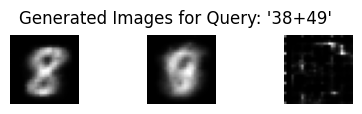

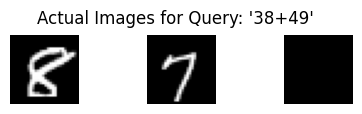

1/1 [==============================] - 0s 34ms/step


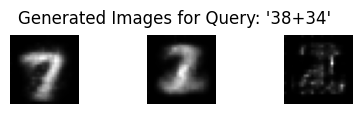

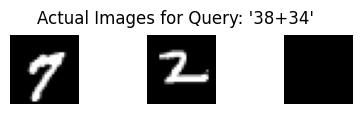

1/1 [==============================] - 0s 30ms/step


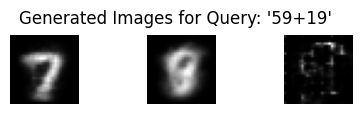

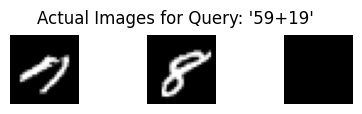

1/1 [==============================] - 0s 29ms/step


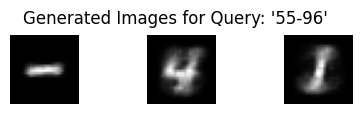

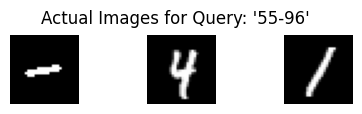

1/1 [==============================] - 0s 29ms/step


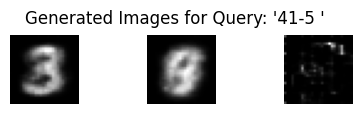

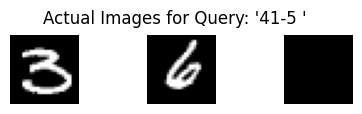

1/1 [==============================] - 0s 31ms/step


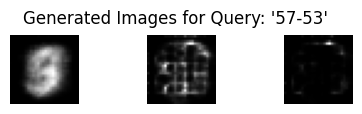

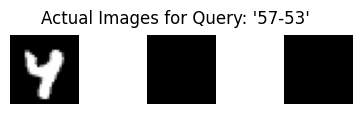

1/1 [==============================] - 0s 44ms/step


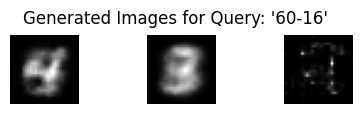

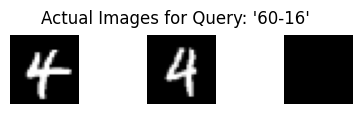

1/1 [==============================] - 0s 33ms/step


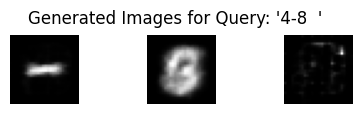

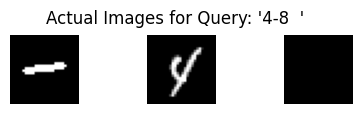

1/1 [==============================] - 0s 40ms/step


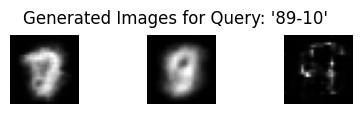

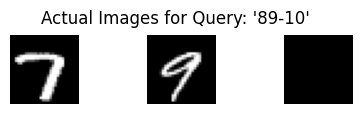

1/1 [==============================] - 0s 30ms/step


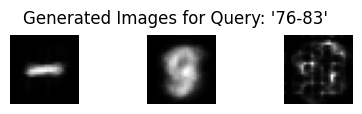

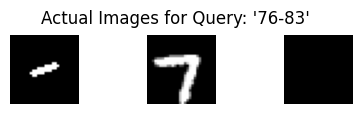

In [ ]:
def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

def plot_images(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(5, 1))  # Adjust the figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(top=0.8)  # Adjust the top spacing
    plt.suptitle(title, y=1.05)  # Adjust the title position
    plt.show()

num_samples_to_visualize = 10
indices = np.random.choice(range(len(X_text_test)), num_samples_to_visualize, replace=False)

for idx in indices:
    # Get the one-hot encoded text query and decode it
    text_query_encoded = X_text_test[idx]
    text_query = decode_one_hot(text_query_encoded)

    # Generate images using the model
    predicted_images = text_to_image_model.predict(text_query_encoded[np.newaxis, ...])

    # Plot the predicted images with the query
    plot_images(predicted_images.squeeze(), f"Generated Images for Query: '{text_query}'")

    # Optionally, plot the actual images for comparison
    actual_images = y_img_test[idx]
    plot_images(actual_images.squeeze(), f"Actual Images for Query: '{text_query}'")

Plot with 100 epochs

1/1 [==============================] - 1s 695ms/step


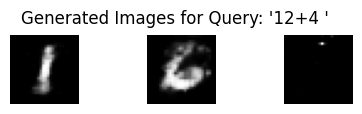

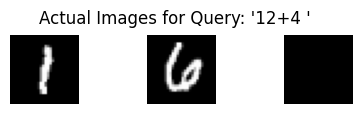

1/1 [==============================] - 0s 26ms/step


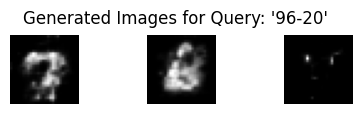

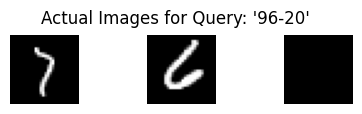

1/1 [==============================] - 0s 26ms/step


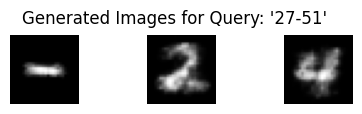

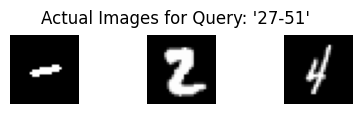

1/1 [==============================] - 0s 28ms/step


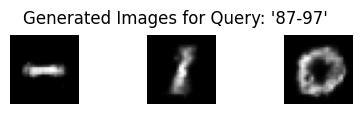

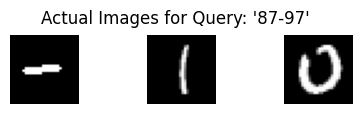

1/1 [==============================] - 0s 34ms/step


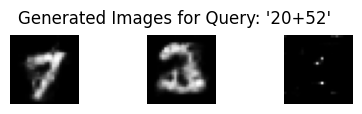

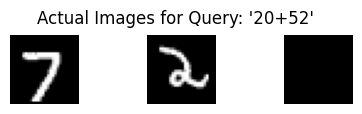

1/1 [==============================] - 0s 29ms/step


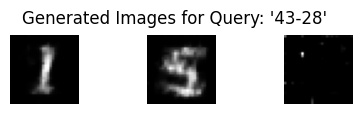

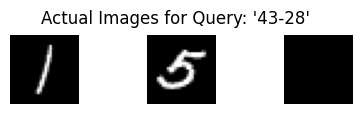

1/1 [==============================] - 0s 33ms/step


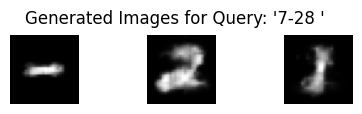

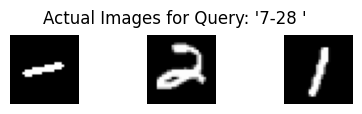

1/1 [==============================] - 0s 32ms/step


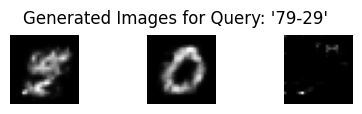

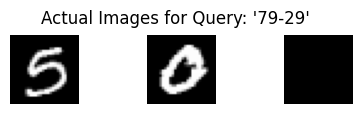

1/1 [==============================] - 0s 26ms/step


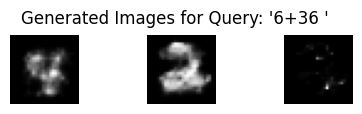

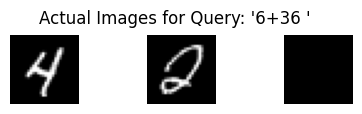

1/1 [==============================] - 0s 31ms/step


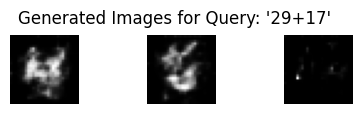

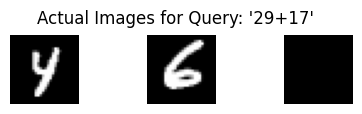

In [15]:
def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

def plot_images(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(5, 1))  # Adjust the figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(top=0.8)  # Adjust the top spacing
    plt.suptitle(title, y=1.05)  # Adjust the title position
    plt.show()

num_samples_to_visualize = 10
indices = np.random.choice(range(len(X_text_test)), num_samples_to_visualize, replace=False)

for idx in indices:
    # Get the one-hot encoded text query and decode it
    text_query_encoded = X_text_test[idx]
    text_query = decode_one_hot(text_query_encoded)

    # Generate images using the model
    predicted_images = text_to_image_model.predict(text_query_encoded[np.newaxis, ...])

    # Plot the predicted images with the query
    plot_images(predicted_images.squeeze(), f"Generated Images for Query: '{text_query}'")

    # Optionally, plot the actual images for comparison
    actual_images = y_img_test[idx]
    plot_images(actual_images.squeeze(), f"Actual Images for Query: '{text_query}'")

Plot with 200 epochs

1/1 [==============================] - 1s 746ms/step


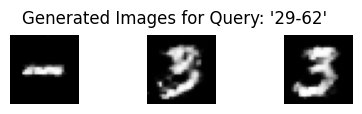

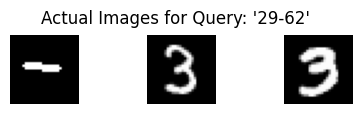

1/1 [==============================] - 0s 34ms/step


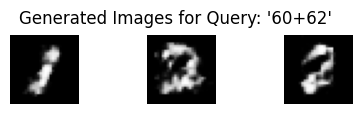

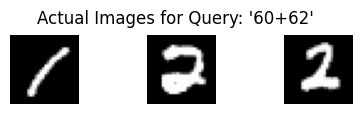

1/1 [==============================] - 0s 34ms/step


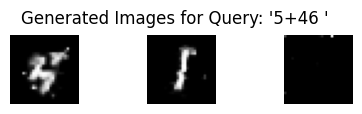

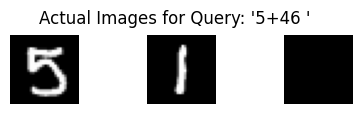

1/1 [==============================] - 0s 31ms/step


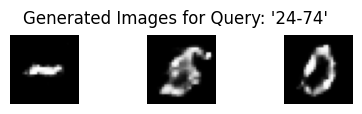

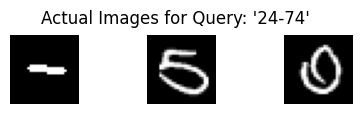

1/1 [==============================] - 0s 28ms/step


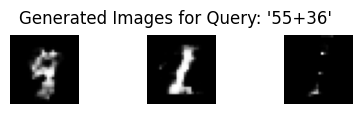

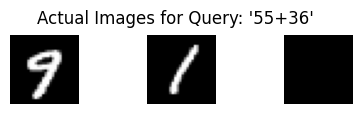

1/1 [==============================] - 0s 32ms/step


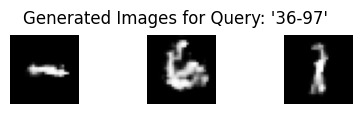

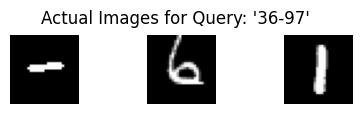

1/1 [==============================] - 0s 30ms/step


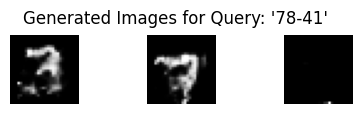

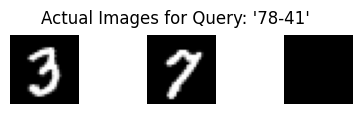

1/1 [==============================] - 0s 29ms/step


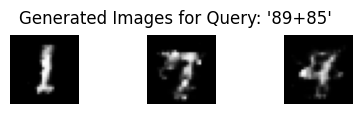

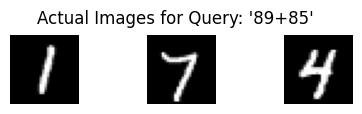

1/1 [==============================] - 0s 27ms/step


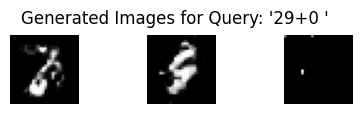

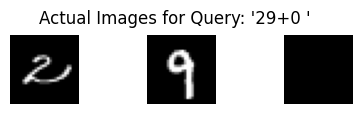

1/1 [==============================] - 0s 28ms/step


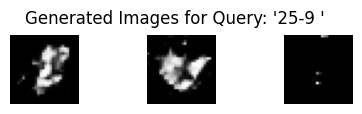

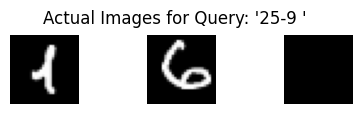

In [13]:
def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

def plot_images(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(5, 1))  # Adjust the figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(top=0.8)  # Adjust the top spacing
    plt.suptitle(title, y=1.05)  # Adjust the title position
    plt.show()

num_samples_to_visualize = 10
indices = np.random.choice(range(len(X_text_test)), num_samples_to_visualize, replace=False)

for idx in indices:
    # Get the one-hot encoded text query and decode it
    text_query_encoded = X_text_test[idx]
    text_query = decode_one_hot(text_query_encoded)

    # Generate images using the model
    predicted_images = text_to_image_model.predict(text_query_encoded[np.newaxis, ...])

    # Plot the predicted images with the query
    plot_images(predicted_images.squeeze(), f"Generated Images for Query: '{text_query}'")

    # Optionally, plot the actual images for comparison
    actual_images = y_img_test[idx]
    plot_images(actual_images.squeeze(), f"Actual Images for Query: '{text_query}'")

##### Plot with 500 epochs

1/1 [==============================] - 1s 904ms/step


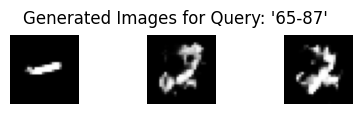

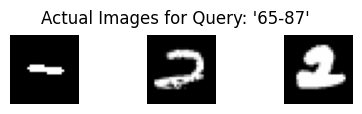

1/1 [==============================] - 0s 29ms/step


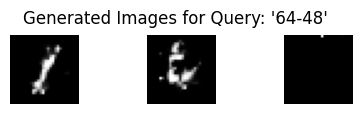

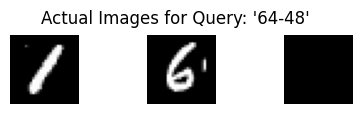

1/1 [==============================] - 0s 38ms/step


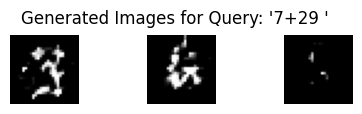

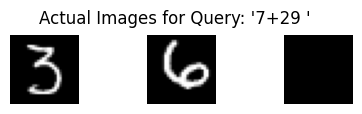

1/1 [==============================] - 0s 26ms/step


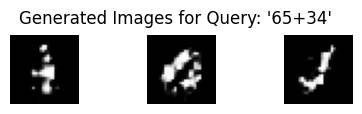

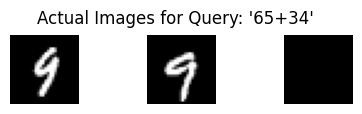

1/1 [==============================] - 0s 36ms/step


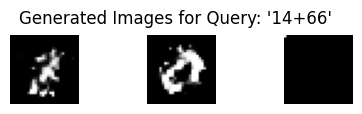

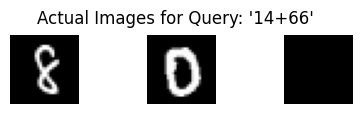

1/1 [==============================] - 0s 36ms/step


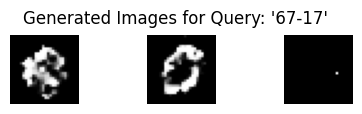

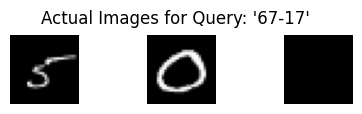

1/1 [==============================] - 0s 44ms/step


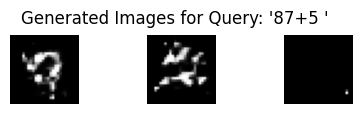

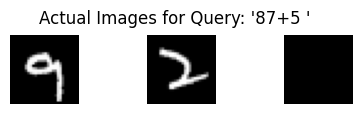

1/1 [==============================] - 0s 37ms/step


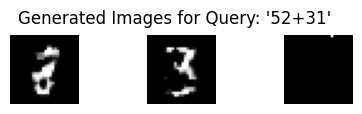

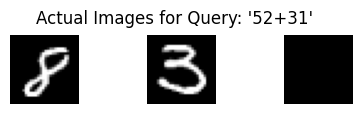

1/1 [==============================] - 0s 31ms/step


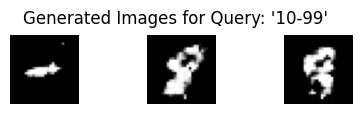

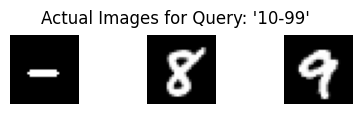

1/1 [==============================] - 0s 41ms/step


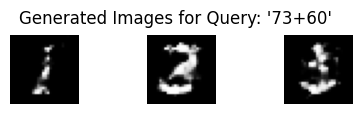

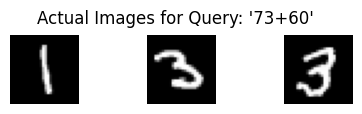

In [ ]:
def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

def plot_images(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(5, 1))  # Adjust the figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(top=0.8)  # Adjust the top spacing
    plt.suptitle(title, y=1.05)  # Adjust the title position
    plt.show()

num_samples_to_visualize = 10
indices = np.random.choice(range(len(X_text_test)), num_samples_to_visualize, replace=False)

for idx in indices:
    # Get the one-hot encoded text query and decode it
    text_query_encoded = X_text_test[idx]
    text_query = decode_one_hot(text_query_encoded)

    # Generate images using the model
    predicted_images = text_to_image_model.predict(text_query_encoded[np.newaxis, ...])

    # Plot the predicted images with the query
    plot_images(predicted_images.squeeze(), f"Generated Images for Query: '{text_query}'")

    # Optionally, plot the actual images for comparison
    actual_images = y_img_test[idx]
    plot_images(actual_images.squeeze(), f"Actual Images for Query: '{text_query}'")

We observe that the example generated images seem to resemble the actual images, which are the correct answers to the arithmetic questions. However, the quality of the generated images is considerably lower than the actual images. But the quality is still good enough to see that the numbers resemble the same numbers as the actual images.

Interestingly the generetad images seem to be of higher quality with 50 epcohs than 500 epochs. The 50 epochs images are a bit blurry but the digits are still readable, while the 500 epoch images are spotted an less reckognizable.

# 1.5: Add extra LSTM layer to text-to-image RNN

In [ ]:
def build_extended_text_to_image_model():
    # Text input encoding
    text_input = Input(shape=(max_query_length, len(unique_characters)))

    # Encoding with additional LSTM layers
    encoded_text = LSTM(256, return_sequences=True)(text_input)
    encoded_text = LSTM(128, return_sequences=False)(encoded_text)  # Last LSTM layer does not return sequences
    repeated_context = RepeatVector(3)(encoded_text)

    # Decoding into image features
    decoded_images = LSTM(128, return_sequences=True)(repeated_context)
    decoded_images = LSTM(64, return_sequences=True)(decoded_images)  # Additional LSTM layer
    decoded_images = TimeDistributed(Dense(7 * 7 * 64))(decoded_images)  # Adjusted size

    # Reshaping to form intermediate images
    images = Reshape((3, 7, 7, 64))(decoded_images)

    # Upsampling to reach the desired image size (28x28)
    images = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))(images)
    images = TimeDistributed(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid'))(images)

    # Compile the model
    model = Model(inputs=text_input, outputs=images)
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model

# Encode the entire dataset
X_text_encoded = encode_labels(X_text)

# Split the encoded data
X_text_train, X_text_test, y_img_train, y_img_test = train_test_split(X_text_encoded, y_img, test_size=0.2, random_state=42)

# Build the text-to-image model
extended_text_to_image_model = build_extended_text_to_image_model()

# Fit the model using the training data
extended_text_to_image_model.fit(X_text_train, y_img_train, epochs=50, batch_size=64, validation_split=0.1)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5, 13)]           0         
                                                                 
 lstm_36 (LSTM)              (None, 5, 256)            276480    
                                                                 
 lstm_37 (LSTM)              (None, 128)               197120    
                                                                 
 repeat_vector_16 (RepeatVe  (None, 3, 128)            0         
 ctor)                                                           
                                                                 
 lstm_38 (LSTM)              (None, 3, 128)            131584    
                                                                 
 lstm_39 (LSTM)              (None, 3, 64)             49408     
                                                           

##### Plot with 50 epochs

1/1 [==============================] - 1s 1s/step


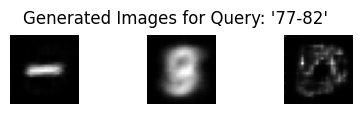

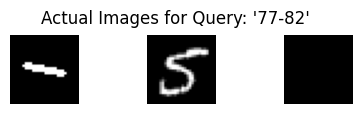

1/1 [==============================] - 0s 31ms/step


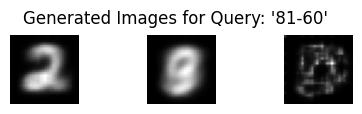

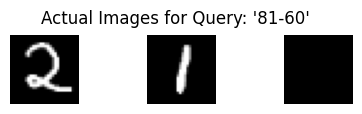

1/1 [==============================] - 0s 36ms/step


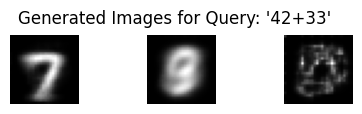

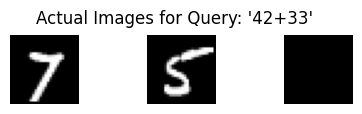

1/1 [==============================] - 0s 31ms/step


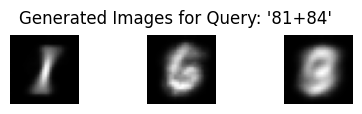

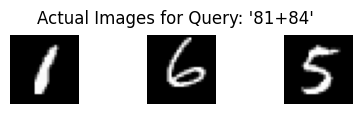

1/1 [==============================] - 0s 30ms/step


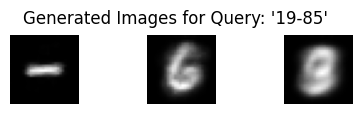

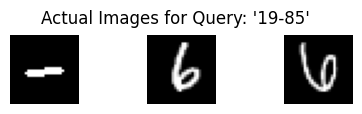

1/1 [==============================] - 0s 39ms/step


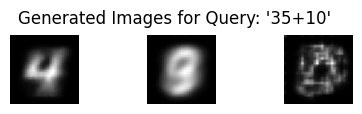

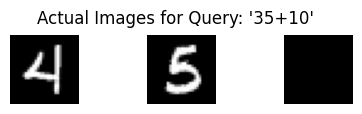

1/1 [==============================] - 0s 33ms/step


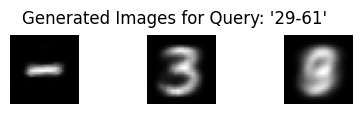

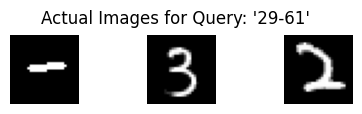

1/1 [==============================] - 0s 56ms/step


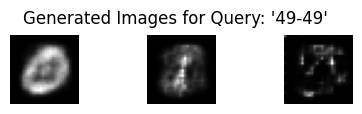

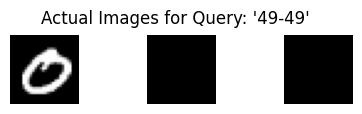

1/1 [==============================] - 0s 31ms/step


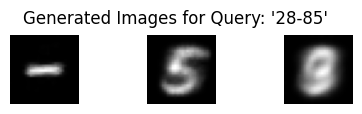

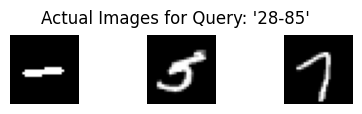

1/1 [==============================] - 0s 33ms/step


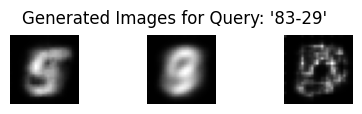

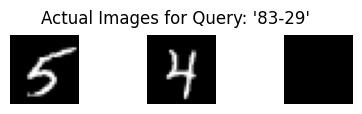

In [ ]:
def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

def plot_images(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(5, 1))  # Adjust the figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(top=0.8)  # Adjust the top spacing
    plt.suptitle(title, y=1.05)  # Adjust the title position
    plt.show()

num_samples_to_visualize = 10
indices = np.random.choice(range(len(X_text_test)), num_samples_to_visualize, replace=False)

for idx in indices:
    # Get the one-hot encoded text query and decode it
    text_query_encoded = X_text_test[idx]
    text_query = decode_one_hot(text_query_encoded)

    # Generate images using the model
    predicted_images = extended_text_to_image_model.predict(text_query_encoded[np.newaxis, ...])

    # Plot the predicted images with the query
    plot_images(predicted_images.squeeze(), f"Generated Images for Query: '{text_query}'")

    # Optionally, plot the actual images for comparison
    actual_images = y_img_test[idx]
    plot_images(actual_images.squeeze(), f"Actual Images for Query: '{text_query}'")

##### Plot with 500 epochs

1/1 [==============================] - 0s 19ms/step


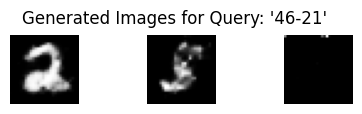

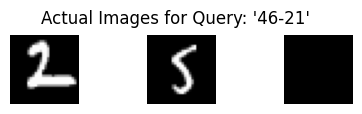

1/1 [==============================] - 0s 27ms/step


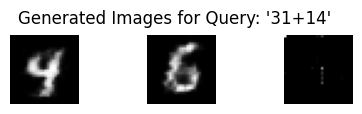

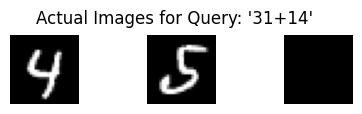

1/1 [==============================] - 0s 30ms/step


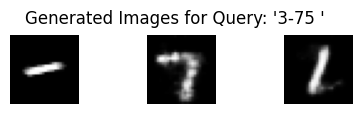

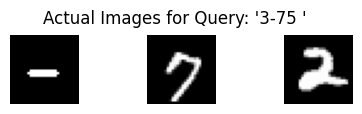

1/1 [==============================] - 0s 32ms/step


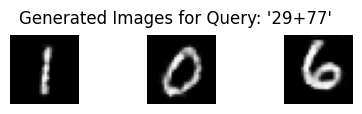

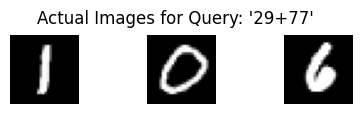

1/1 [==============================] - 0s 26ms/step


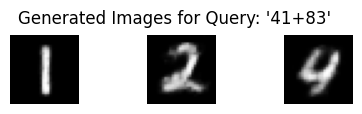

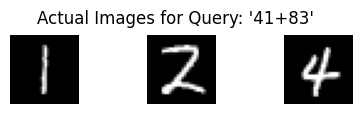

1/1 [==============================] - 0s 36ms/step


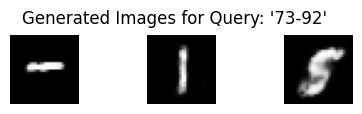

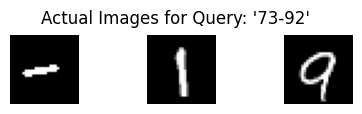

1/1 [==============================] - 0s 25ms/step


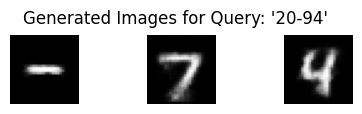

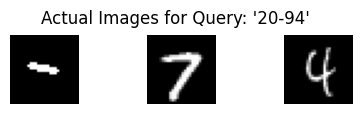

1/1 [==============================] - 0s 25ms/step


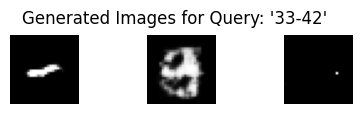

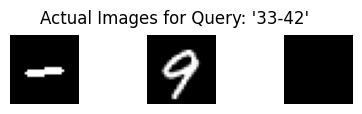

1/1 [==============================] - 0s 38ms/step


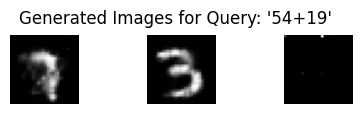

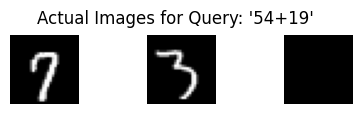

1/1 [==============================] - 0s 30ms/step


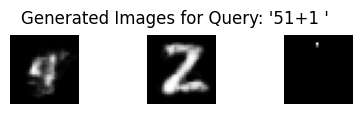

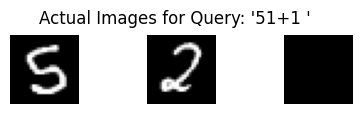

In [ ]:
def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

def plot_images(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(5, 1))  # Adjust the figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(top=0.8)  # Adjust the top spacing
    plt.suptitle(title, y=1.05)  # Adjust the title position
    plt.show()

num_samples_to_visualize = 10
indices = np.random.choice(range(len(X_text_test)), num_samples_to_visualize, replace=False)

for idx in indices:
    # Get the one-hot encoded text query and decode it
    text_query_encoded = X_text_test[idx]
    text_query = decode_one_hot(text_query_encoded)

    # Generate images using the model
    predicted_images = extended_text_to_image_model.predict(text_query_encoded[np.newaxis, ...])

    # Plot the predicted images with the query
    plot_images(predicted_images.squeeze(), f"Generated Images for Query: '{text_query}'")

    # Optionally, plot the actual images for comparison
    actual_images = y_img_test[idx]
    plot_images(actual_images.squeeze(), f"Actual Images for Query: '{text_query}'")

We observe that the quality of the generated images has considerably improved compared to the model with only a single LSTM layer, especially for the 500 epoch double LSTM layer. The 50 epoch images seem to be a bit clearer for double LSTM layer compared to single, and the double LSTM layer seems to increase in clarity when increaseing epochs from 50 to 500.

This can have multiple reasons:
Increase model capacity: adding an extra layer to a model simply allows it to learn more complex patterns. This helps it in detecting more intricate details.

Better contextualization: The extra layer allows for increased context awareness. Where the first layer might be able to capture basic patterns, the extra layer might be able to combine these basic patterns in more meaningful features.

Improved gradient flow: Multiple layers can facilitate better gradient flow during backpropogation, which can lead to more effective learning.


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #7977

X_text: "79*77" = y_text: "6083 "


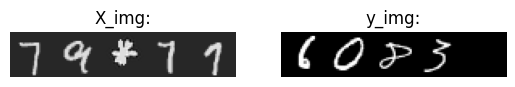

Query #7215

X_text: "72*15" = y_text: "1080 "


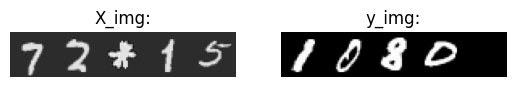

Query #7471

X_text: "74*71" = y_text: "5254 "


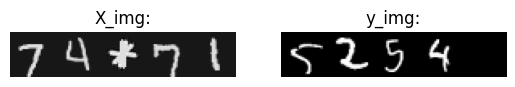

Query #6173

X_text: "61*73" = y_text: "4453 "


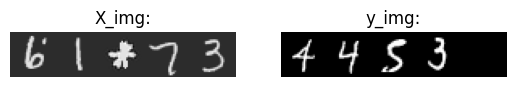

Query #1916

X_text: "19*16" = y_text: "304  "


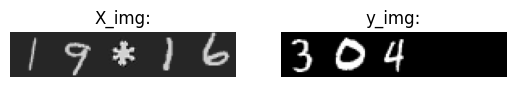

Query #3145

X_text: "31*45" = y_text: "1395 "


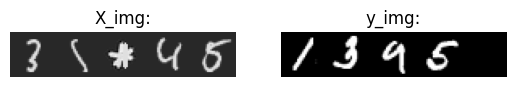

Query #4927

X_text: "49*27" = y_text: "1323 "


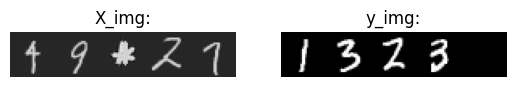

Query #527

X_text: "5*27 " = y_text: "135  "


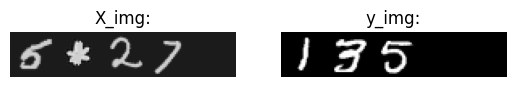

Query #9748

X_text: "97*48" = y_text: "4656 "


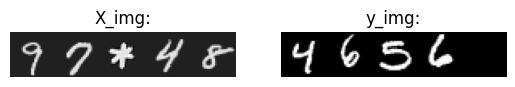

Query #1641

X_text: "16*41" = y_text: "656  "


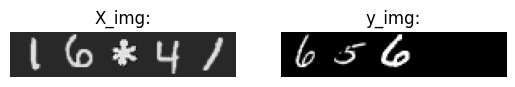

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

# 2.2 Text-to-text multiplication model

In [ ]:
## Your code

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

### Text-to-text model multiplication

def build_text2text_multiplication_model():
    text2text = tf.keras.Sequential()

    # Input shape: max_query_length, len(unique_characters)
    text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

    # Output length for multiplication might be different
    text2text.add(RepeatVector(max_answer_length))

    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text


def decode_one_hot(one_hot_encoded_query):
    return ''.join(unique_characters[np.argmax(char_vector)] for char_vector in one_hot_encoded_query)

from collections import Counter

# Modified function to collect all misclassification errors
def collect_misclassification_errors(predictions, y_test):
    errors = []
    for idx in range(len(predictions)):
        predicted_label = decode_labels(predictions[idx])
        true_label = decode_labels(y_test[idx])
        if predicted_label != true_label:
            errors.append((idx, true_label, predicted_label))
    return errors

def display_top_misclassification_mistakes(errors, X_test_encoded):
    print("Top 10 Misclassification Mistakes:")
    error_counter = Counter((true_label, predicted_label) for _, true_label, predicted_label in errors)

    for mistake, count in error_counter.most_common(10):
        true_label, predicted_label = mistake
        indices = [idx for idx, true, pred in errors if true == true_label and pred == predicted_label][:10]

        print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Count: {count}")
        for idx in indices:
            query = decode_one_hot(X_test_encoded[idx])
            print(f"  Query '{query}' at Index {idx}")

# Splits for training and testing
splits = [(0.8, 0.2), (0.5, 0.5), (0.25, 0.75), (0.1, 0.9)]

# Collecting errors for each split
split_errors = {}

# Initializing dictionaries to store accuracy data
train_accuracies = {}
val_accuracies = {}

for train_size, test_size in splits:
    print(f"Training with split {train_size}-{test_size}")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=train_size, test_size=test_size, random_state=42)

    # Build and train the model
    model = build_text2text_multiplication_model()
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

    # Storing accuracies for plotting
    train_accuracies[f"{train_size}"] = history.history['accuracy']
    val_accuracies[f"{train_size}"] = history.history['val_accuracy']

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy}")

    # Collect misclassification errors
    predictions = model.predict(X_test)
    split_errors[f"{train_size}"] = collect_misclassification_errors(predictions, y_test)



Training with split 0.8-0.2
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               275456    
                                                                 
 repeat_vector_4 (RepeatVec  (None, 5, 256)            0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 12)             3084      
 stributed)                                                      
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________

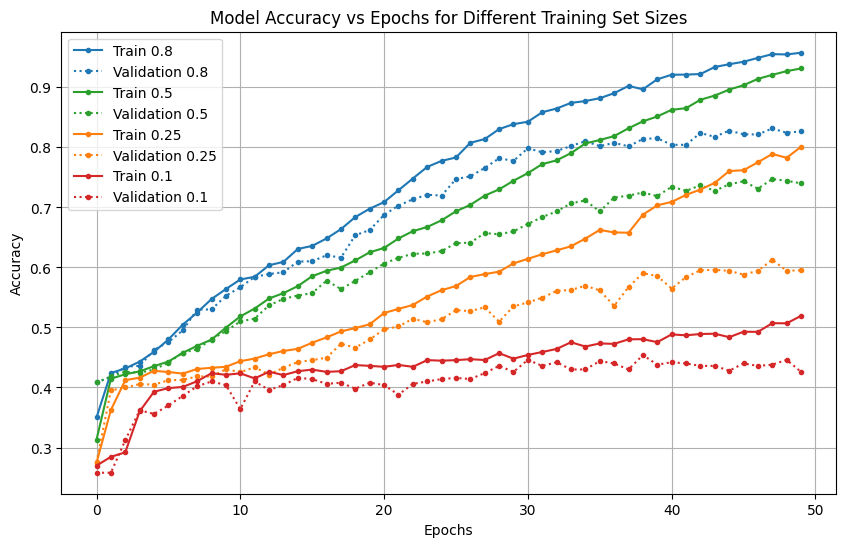

In [ ]:
# Define a list of colors for the plots
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

# Plotting
plt.figure(figsize=(10, 6))
for i, train_size in enumerate(splits):
    split = train_size[0]
    color = colors[i]
    plt.plot(train_accuracies[f"{split}"], label=f"Train {split}", color=color, marker='.')
    plt.plot(val_accuracies[f"{split}"], linestyle='dotted', label=f"Validation {split}", color=color, marker='.')

plt.title("Model Accuracy vs Epochs for Different Training Set Sizes")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

We observe overfitting at an earlier stage, meaning that this model has less generalization power compared to the text-to-text model for basic arithmetics.

The results from the top missclassification mistakes corroborate this, as some mistakes involve 2 wrong digits compared to only 1 in the text-to-text model for basic arithmetics.

In [ ]:
# Display top misclassification mistakes for each split
for train_size, errors in split_errors.items():
    print(f"\nFor Training Split {train_size}")
    display_top_misclassification_mistakes(errors, X_test)


For Training Split 0.8
Top 10 Misclassification Mistakes:
True Label: 1092 , Predicted Label: 1112 , Count: 3
  Query '84*13' at Index 466
  Query '52*21' at Index 637
  Query '21*52' at Index 1983
True Label: 3864 , Predicted Label: 3884 , Count: 2
  Query '46*84' at Index 1
  Query '84*46' at Index 153
True Label: 945  , Predicted Label: 905  , Count: 2
  Query '45*21' at Index 4
  Query '21*45' at Index 631
True Label: 195  , Predicted Label: 285  , Count: 2
  Query '15*13' at Index 43
  Query '13*15' at Index 64
True Label: 1581 , Predicted Label: 1661 , Count: 2
  Query '93*17' at Index 44
  Query '17*93' at Index 1048
True Label: 1020 , Predicted Label: 1000 , Count: 2
  Query '17*60' at Index 48
  Query '12*85' at Index 1464
True Label: 165  , Predicted Label: 155  , Count: 2
  Query '33*5 ' at Index 86
  Query '55*3 ' at Index 928
True Label: 1152 , Predicted Label: 1112 , Count: 2
  Query '72*16' at Index 120
  Query '16*72' at Index 972
True Label: 682  , Predicted Label: 60

# 2.2 Image-to-text multiplication model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 28, 28, 1)]    0         
                                                                 
 time_distributed_9 (TimeDi  (None, 5, 26, 26, 32)     320       
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 5, 13, 13, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 5, 5408)           0         
 istributed)                                                     
                                                                 
 lstm_16 (LSTM)              (None, 128)               2834944   
                                                             

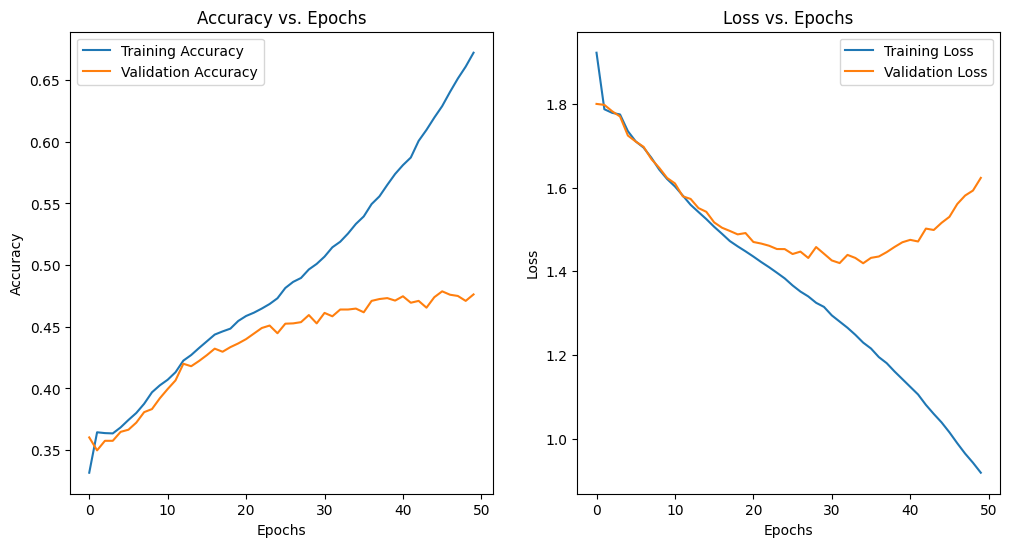

In [ ]:
X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

def build_image_to_text_multiplication_model():
    input_shape = (5, 28, 28, 1)  # Assuming 5 images for each query, modify if needed

    # Adjust max_answer_length for multiplication
    max_answer_length = 5  # Maximum length of multiplication answer
    unique_characters = '0123456789* '  # Adjust as per the multiplication dataset

    # Building the model
    input_layer = Input(shape=input_shape)
    cnn = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'))(input_layer)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
    cnn = TimeDistributed(Flatten())(cnn)
    lstm = LSTM(128)(cnn)
    repeated_context = RepeatVector(max_answer_length)(lstm)
    lstm_output = LSTM(128, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(lstm_output)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

# Prepare and split the data (assuming you've already loaded and prepared X_img and y_text for multiplication)
X_img_reshaped = X_img.reshape((-1, 5, 28, 28, 1)) / 255.0
X_train, X_test, y_train, y_test = train_test_split(X_img_reshaped, y_text_onehot, train_size=0.8, test_size=0.2, random_state=42)

# Build and train the model
image_to_text_multiplication_model = build_image_to_text_multiplication_model()
history = image_to_text_multiplication_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

# Evaluate the model
loss, accuracy = image_to_text_multiplication_model.evaluate(X_test, y_test)
print(f"Image-to-Text Multiplication Model Test Accuracy: {accuracy}")

# Plotting the learning curves
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 2.3: Hyperparameter and model architecture tuning to increase model accuracy

We can add a second LSTM layer to improve the model. Apparently it doesn;t seem to work. THERE IS STILL SOME WORK TO BE DONE HERE AS WE CAN TWEAK THE MODEL FURTHER TO INCREASE ACCURACY.

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5, 28, 28, 1)]    0         
                                                                 
 time_distributed_38 (TimeD  (None, 5, 26, 26, 32)     320       
 istributed)                                                     
                                                                 
 time_distributed_39 (TimeD  (None, 5, 13, 13, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, 5, 5408)           0         
 istributed)                                                     
                                                                 
 lstm_41 (LSTM)              (None, 128)               2834944   
                                                           

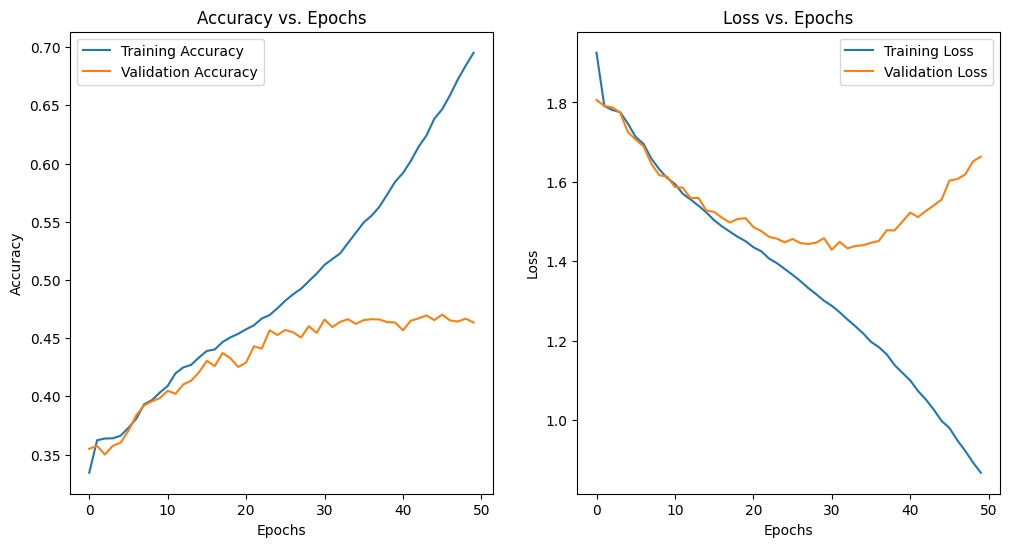

In [ ]:
X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

def build_image_to_text_multiplication_model():
    input_shape = (5, 28, 28, 1)  # Assuming 5 images for each query, modify if needed

    # Adjust max_answer_length for multiplication
    max_answer_length = 5  # Maximum length of multiplication answer
    unique_characters = '0123456789* '  # Adjust as per the multiplication dataset

    # Building the model
    input_layer = Input(shape=input_shape)
    cnn = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'))(input_layer)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
    cnn = TimeDistributed(Flatten())(cnn)
    lstm = LSTM(128, return_sequences=True)(cnn)
    lstm = LSTM(128)(cnn)
    repeated_context = RepeatVector(max_answer_length)(lstm)
    lstm_output = LSTM(128, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(lstm_output)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

# Prepare and split the data (assuming you've already loaded and prepared X_img and y_text for multiplication)
X_img_reshaped = X_img.reshape((-1, 5, 28, 28, 1)) / 255.0
X_train, X_test, y_train, y_test = train_test_split(X_img_reshaped, y_text_onehot, train_size=0.8, test_size=0.2, random_state=42)

# Build and train the model
image_to_text_multiplication_model = build_image_to_text_multiplication_model()
history = image_to_text_multiplication_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

# Evaluate the model
loss, accuracy = image_to_text_multiplication_model.evaluate(X_test, y_test)
print(f"Image-to-Text Multiplication Model Test Accuracy: {accuracy}")

# Plotting the learning curves
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()